# **Lab 11: Image Classification with Convolutional Neural Networks (CNNs)**

### Importing packages

The new package this week is `torchvision`, as it depends on Pytorch and their versions need to be compatible, unistall your torch version and then reinstall known compatible versions of both packages with either pip or conda with the code as shown below:


`conda install pytorch==2.1.0 torchvision==0.16.0 -c pytorch`

(`pip install torch==2.1.0 torchvision==0.16.0` if you prefer)

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Here again we have the code to select device, CPU is plenty for this task.

In [18]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cpu


### Loading and Exploring the MNIST Dataset

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Load the full training set
train_val_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# Split: 90% train, 10% validation
train_size = int(0.9 * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Test set
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Let's display 5 example images from the dataset with their labels, to get an idea of what they look like.

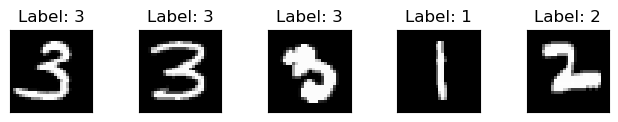

In [20]:

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples) # Get one batch of training data

fig = plt.figure()
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Label: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

## Defining a Simple CNN

### Understanding the CNN Architecture

Let's break down the `SimpleCNN` model below to understand how each layer works and why specific hyperparameters are chosen.

#### 🔹 Convolutional Layer 1
```python
nn.Conv2d(1, 16, kernel_size=3, padding=1)
```
- **Input channels**: 1 (grayscale MNIST images).
- **Output channels**: 16. This means we are learning 16 different filters/features from the input.
- **Kernel size**: 3×3. A small receptive field that captures local patterns like edges.
- **Padding**: 1. This ensures the output feature map has the same spatial dimensions as the input (28×28), preserving edge information.

#### 🔹 Activation Function: ReLU
```python
nn.ReLU()
```
- Introduces non-linearity, allowing the model to learn more complex patterns.
- ReLU replaces all negative values with zero, helping avoid vanishing gradients.

#### 🔹 Max Pooling Layer 1
```python
nn.MaxPool2d(2)
```
- **Kernel size**: 2×2.
- **Effect**: Downsamples the feature map by a factor of 2 (from 28×28 to 14×14).
- This reduces spatial dimensions and computational cost, while retaining important features.

---

#### 🔹 Convolutional Layer 2
```python
nn.Conv2d(16, 32, kernel_size=3, padding=1)
```
- **Input channels**: 16 (output from previous layer).
- **Output channels**: 32. We are now learning 32 higher-level features.
- **Kernel size and padding**: Same as before to preserve spatial size pre-pooling.

#### 🔹 Activation Function and Max Pooling Layer 2
```python
nn.ReLU(), nn.MaxPool2d(2)
```
- Again apply ReLU followed by 2×2 max pooling.
- **Resulting dimensions**: The 14×14 feature maps become 7×7, with 32 channels.

---

### 🔸 Fully Connected Layers

Before we can use fully connected (dense) layers, we need to **flatten** the 3D tensor output from the convolutional layers:
- From shape: `(batch_size, 32, 7, 7)`
- To shape: `(batch_size, 32 * 7 * 7) = (batch_size, 1568)`

```python
nn.Flatten(),
nn.Linear(32 * 7 * 7, 100),
nn.ReLU()
```
- **First Linear Layer**:
  - Input: 1568 features.
  - Output: 100 neurons.
  - Acts as a classic MLP hidden layer to mix the features.

```python
nn.Linear(100, 10)
```
- Final layer that maps the 100 features to **10 output classes** (digits 0 through 9).


In [21]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 7 * 7, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

Instantiate the model, move it to the device, and print the model summary.

In [22]:
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (conv_layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=10, bias=True)
  )
)


## Creating a training and testing loop

As with last week we create loops for training and testing specific to this dataset and the task.

In [23]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = 100 * correct / total
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch [{epoch+1}/{epochs}] Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

        
def evaluate_model(model, data_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    model.to(device)
    
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Training the CNN

In [24]:
model = SimpleCNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses = train_model(model, train_loader, val_loader, optimizer, criterion, epochs=5)


Epoch [1/5] Loss: 0.2265, Train Acc: 93.36%, Val Loss: 0.0718
Epoch [2/5] Loss: 0.0594, Train Acc: 98.16%, Val Loss: 0.0525
Epoch [3/5] Loss: 0.0430, Train Acc: 98.65%, Val Loss: 0.0493
Epoch [4/5] Loss: 0.0313, Train Acc: 99.02%, Val Loss: 0.0409
Epoch [5/5] Loss: 0.0254, Train Acc: 99.22%, Val Loss: 0.0401


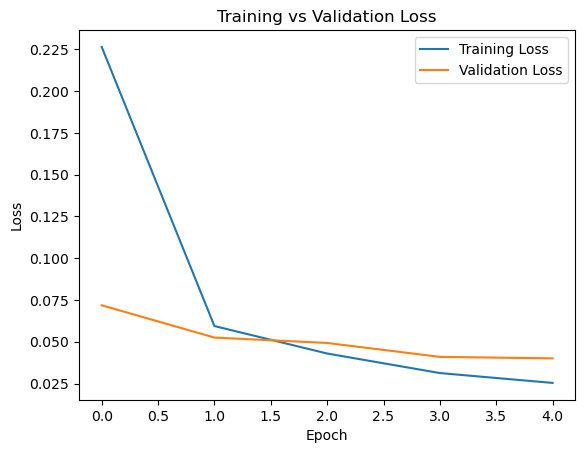

In [25]:
# Plotting
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

### Evaluating and Visualising Results

In [26]:
test_accuracy = evaluate_model(model, test_loader)
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Final Test Accuracy: 98.99%


Displaying 10 test images with predicted and actual labels.

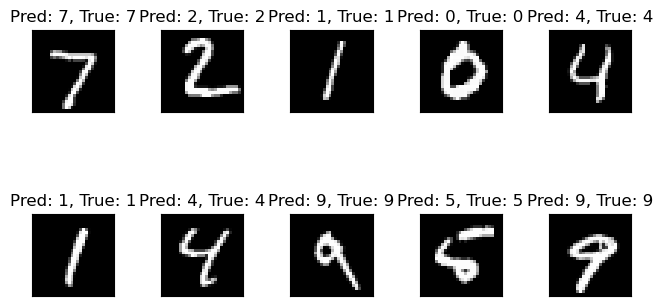

In [27]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data, example_targets = example_data.to(device), example_targets.to(device)

output = model(example_data)
_, preds = torch.max(output, 1)

fig = plt.figure()
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0].cpu(), cmap='gray', interpolation='none')
    plt.title(f"Pred: {preds[i]}, True: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])
plt.show()

# Your Task: Improve on this model!

As with last week I want you to try mess with this model to get a sense of how changing the parameters can improve, or break the model.

Here are some basic suggestions, but feel free to look online for even more suggestions on things you can change! (Try not to just copy in other architectures completely, but instead incorporate elements they have into our model.)

- **Network Architecture**
  - Add an extra convolutional layer
  - Increase or decrease number of filters (e.g. 32 → 64)
  - Change kernel size (e.g. 3×3 → 5×5)
  - Use more fully connected layers or increase hidden units

- **Regularization**
  - Add Dropout after conv or linear layers
  - Apply L2 weight decay via the optimizer

- **Training Settings**
  - Switch optimizer (SGD + momentum, AdamW)
  - Change learning rate

- **Activation Functions**
  - Try LeakyReLU, ELU, Sigmoid or GELU instead of ReLU